<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Tackling an NLP Problem with Naive Bayes
_Author: Matt Brems_

----

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we are going to apply a **new** modeling technique to natural language processing data.

> "But how can we apply a modeling technique we haven't learned?!"

The DSI program is great - but we can't teach you *everything* about data science in 12 weeks! This lab is designed to help you start learning something new without it being taught in a formal lesson. 
- Later in the cohort (like for your capstone!), you'll be exploring models, libraries, and resources that you haven't been explicitly taught.
- After the program, you'll want to continue developing your skills. Being comfortable with documentation and being confident in your ability to read something new and decide whether or not it is an appropriate method for the problem you're trying to solve is **incredibly** valuable.

### Step 1: Define the problem.

Many organizations have a substantial interest in classifying users of their product into groups. Some examples:
- A company that serves as a marketplace may want to predict who is likely to purchase a certain type of product on their platform, like books, cars, or food.
- An application developer may want to identify which individuals are willing to pay money for "bonus features" or to upgrade their app.
- A social media organization may want to identify who generates the highest rate of content that later goes "viral."

### Summary
In this lab, you're an engineer for Facebook. In recent years, the organization Cambridge Analytica gained worldwide notoriety for its use of Facebook data in an attempt to sway electoral outcomes.

Cambridge Analytica, an organization staffed with lots of Ph.D. researchers, used the Big5 personality groupings (also called OCEAN) to group people into one of 32 different groups.
- The five qualities measured by this personality assessment are:
    - **O**penness
    - **C**onscientiousness
    - **E**xtroversion
    - **A**greeableness
    - **N**euroticism
- Each person could be classified as "Yes" or "No" for each of the five qualities.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$)
- You don't have to check it out, but if you want to learn more about this personality assessment, head to [the Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits).
- There's also [a short (3-4 pages) academic paper describing part of this approach](./celli-al_wcpr13.pdf).

Cambridge Analytica's methodology was, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big5 personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

You want to know the **real-world problem**: "Is what Cambridge Analytica attempted to do actually possible, or is it junk science?"

However, we'll solve the related **data science problem**: "Are one's Facebook statuses predictive of whether or not one is agreeable?"
> Note: If Facebook statuses aren't predictive of one being agreeable (one of the OCEAN qualities), then Cambridge Analytica's approach won't work very well!

### Step 2: Obtain the data.

Obviously, there are plenty of opportunities to discuss the ethics surrounding this particular issue... so let's do that.

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
#from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
sns.set(style='white')

In [2]:
data = pd.read_csv('./mypersonality_final.csv', encoding = 'ISO-8859-1')

In [3]:
data.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1


**1. What is the difference between anonymity and confidentiality? All else held equal, which tends to keep people safer?**

Anonymity means you don’t know who the participants are, while confidentiality means you know who they are but remove identifying information from your research report. Both are important ethical considerations.

You can only guarantee anonymity by not collecting any personally identifying information—for example, names, phone numbers, email addresses, IP addresses, physical characteristics, photos, or videos.

You can keep data confidential by using aggregate information in your research report, so that you only refer to groups of participants rather than individuals.

**2. Suppose that the "unique identifier" in the above data, the `#AUTHID`, is a randomly generated key so that it can never be connected back to the original poster. Have we guaranteed anonymity here? Why or why not?**

Theoritically yes, however, using information collectively from the status could potentially connect ack to the original poster.

**3. As an engineer for Facebook, you recognize that user data will be used by Facebook and by other organizations - that won't change. However, what are at least three recommendations you would bring to your manager to improve how data is used and shared? Be as specific as you can.**

- Remove all personal information from status and data such as for names, tagged name, phone numbers, email addresses, IP addresses, physical characteristics, photos, or videos.

### Step 3: Explore the data.

- Note: For our $X$ variable, we will only use the `STATUS` variable. For our $Y$ variable, we will only use the `cAGR` variable.

**4. Explore the data here.**
> We aren't explicitly asking you to do specific EDA here, but what EDA would you generally do with this data? Do the EDA you usually would, especially if you know what the goal of this analysis is.

- explore status lenght, status word count, average status lenght:  thier distributions and  relationships
- number of unique identifier
- the status lenght, status word count, average status lenght by cAGR group
- most and least common words used by cAGR group

**5. What is the difference between CountVectorizer and TFIDFVectorizer?**

CountVectorizer counts up how many times a token is observed in a given document. 
While, TF-IDF  analyze the importance of a word relatively to other words in the document .
Words that occur often in one document but don't occur in many documents contain more predictive power.


**6. What are stopwords?**

Stop words and they are typically articles, prepositions, conjunctions, or pronouns.
Stop words generates a list of words that will not be included as a feature. 
The primary use of this is the “English” dictionary where it will get rid of insignificant words like “is, the, a, it, as “which can appear quite frequently, 
but have little to no influence on our end goal.

**7. Give an example of when you might remove stopwords.**

We might want to remove stopwords when we want to analyse a sentiment analysis, because, these words have little influence or meaning to sentiment. 

**8. Give an example of when you might keep stopwords in your model.**

We might want to keep stopwords when we want analyze the use of this stopwords in text. 
For example the misuse of articles in essay writing from students. 

### Step 4: Model the data.

We are going to fit two types of models: a logistic regression and [a Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html).

**Reminder:** We will only use the feature `STATUS` to model `cAGR`.

### We want to attempt to fit our models on sixteen sets of features:

1. CountVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
2. CountVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
3. CountVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
4. CountVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
5. CountVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
6. CountVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
7. CountVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
8. CountVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.
9. TFIDFVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
10. TFIDFVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
11. TFIDFVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
12. TFIDFVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
13. TFIDFVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
14. TFIDFVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
15. TFIDFVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
16. TFIDFVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.

**9. Rather than manually instantiating 16 different vectorizers, what `sklearn` class have we learned about that might make this easier? Use it.**

In [13]:
# Change label of cAGR to binary code: yes =1 , no =0
data['cAGR'] = data['cAGR'].map({'n':0, 'y':1})

In [14]:
data['cAGR'].value_counts()  # the proportion of two class are similar, unbalance classes are not concerned here. 

1    5268
0    4649
Name: cAGR, dtype: int64

In [19]:
#Assembly X and y variables
X = data['STATUS']
y = data['cAGR']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [20]:
#check shape of data 
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6644,), (3273,), (6644,), (3273,))

In [21]:
#Baseline accuracy
y_train.value_counts(normalize = True).mul(100).round(2)

1    53.12
0    46.88
Name: cAGR, dtype: float64

In [28]:
#Gridsearch using CountVectorizer

# Instantiate the transformer.
cvec = CountVectorizer()


#Define Pipeline
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()), #transformer (fit, transform)
    ('nb', MultinomialNB())  #estimator or model (fit, predict)
])

# Define hyperparameter
pipe_params_cvec = {
    'cvec__max_features': [100, 500],
    'cvec__stop_words' : [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)]  
}

In [29]:
# Instantiate GridSearchCV

gs_cvec = GridSearchCV(pipe_cvec, # what object are we optimizing?
                  param_grid= pipe_params_cvec, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

# Fit GridSearch to training data
gs_cvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [100, 500],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']})

In [35]:
#Model evaluation
print(f"Score on training data: {gs_cvec.score(X_train, y_train)}")
print(f"Score on testing data: {gs_cvec.score(X_test, y_test)}")
print(f"Best scores : {gs_cvec.best_score_}")
print(f"Best hyperparameter : {gs_cvec.best_params_}")
print(f"Best hyperparameter : {gs_cvec.best_estimator_}")

Score on training data: 0.6101745936183022
Score on testing data: 0.5392606171707913
Best scores : 0.5427461539158893
Best hyperparameter : {'cvec__max_features': 500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
Best hyperparameter : Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=500, stop_words='english')),
                ('nb', MultinomialNB())])


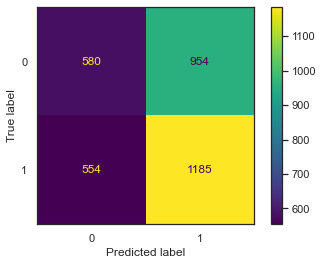

In [45]:
# Get predictions
y_preds_cvec = gs_cvec.predict(X_test)
# Save confusion matrix values
cm_cvec = confusion_matrix(y_test, y_preds_cvec)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm_cvec, 
                       display_labels=gs_cvec.classes_).plot();

In [52]:
print(classification_report(y_test, y_preds_cvec))

              precision    recall  f1-score   support

           0       0.51      0.38      0.43      1534
           1       0.55      0.68      0.61      1739

    accuracy                           0.54      3273
   macro avg       0.53      0.53      0.52      3273
weighted avg       0.53      0.54      0.53      3273



In [41]:
#Gridsearch using TfidfVectorizer

# Instantiate the transformer.
tvec =TfidfVectorizer()

#Define Pipeline
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()), #transformer (fit, transform)
    ('nb', MultinomialNB())  #estimator or model (fit, predict)
])

# Define hyperparameter
pipe_params_tvec = {
    'tvec__max_features': [100, 500],
    'tvec__stop_words' : [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]  
}

# Instantiate GridSearchCV

gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                  param_grid= pipe_params_tvec, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

# Fit GridSearch to training data
gs_tvec.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [100, 500],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [42]:
#Model evaluation
print(f"Score on training data: {gs_tvec.score(X_train, y_train)}")
print(f"Score on testing data: {gs_tvec.score(X_test, y_test)}")
print(f"Best scores : {gs_tvec.best_score_}")
print(f"Best hyperparameter : {gs_tvec.best_params_}")
print(f"Best hyperparameter : {gs_tvec.best_estimator_}")

Score on training data: 0.6205599036724865
Score on testing data: 0.5462878093492209
Best scores : 0.548762884495091
Best hyperparameter : {'tvec__max_features': 500, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}
Best hyperparameter : Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=500, stop_words='english')),
                ('nb', MultinomialNB())])


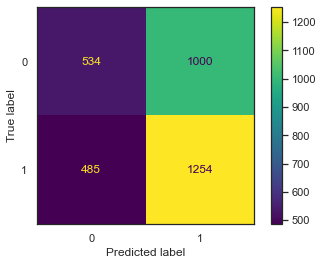

In [46]:
# Get predictions
y_preds_tvec = gs_tvec.predict(X_test)
# Save confusion matrix values
cm_tvec = confusion_matrix(y_test, y_preds_tvec)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm_tvec, 
                       display_labels=gs_tvec.classes_).plot();

In [53]:
print(classification_report(y_test, y_preds_tvec))

              precision    recall  f1-score   support

           0       0.52      0.35      0.42      1534
           1       0.56      0.72      0.63      1739

    accuracy                           0.55      3273
   macro avg       0.54      0.53      0.52      3273
weighted avg       0.54      0.55      0.53      3273



The accuracy score from Naive Bayes classifier model using Tfidf Vectorizer is similar to Naive Bayes classifier model using counter Vectorizer. 

**10. What are some of the advantages of fitting a logistic regression model?**

Logistic regression model provide coefficients which is easier to interpret , understand, and communicate especially to general audiences. 

**11. Fit a logistic regression model and compare it to the baseline.**

In [57]:
#Define Pipeline
pipe_logreg = Pipeline([('cv', CountVectorizer()),
                                ('lr', LogisticRegression())
                       ])

# Define hyperparameter
pipe_params_logreg = {'cv__max_features': [5,10,25,50,100],
                'cv__stop_words':   [None,'english'],
                'cv__ngram_range':  [(1,1),(1,2)]
                     }

# Instantiate GridSearchCV

gs_logreg = GridSearchCV(pipe_logreg, # what object are we optimizing?
                  param_grid= pipe_params_logreg, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

gs_logreg = GridSearchCV(pipe_logreg,pipe_params_logreg,cv=5)
gs_logreg.fit(X_train, y_train)
# Fit GridSearch to training data
gs_logreg.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cv__max_features': [5, 10, 25, 50, 100],
                         'cv__ngram_range': [(1, 1), (1, 2)],
                         'cv__stop_words': [None, 'english']})

In [58]:
#Model evaluation
print(f"Score on training data: {gs_logreg.score(X_train, y_train)}")
print(f"Score on testing data: {gs_logreg.score(X_test, y_test)}")
print(f"Best scores : {gs_logreg.best_score_}")
print(f"Best hyperparameter : {gs_logreg.best_params_}")
print(f"Best hyperparameter : {gs_logreg.best_estimator_}")

Score on training data: 0.5674292594822397
Score on testing data: 0.5111518484570731
Best scores : 0.540487344411506
Best hyperparameter : {'cv__max_features': 100, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}
Best hyperparameter : Pipeline(steps=[('cv', CountVectorizer(max_features=100, stop_words='english')),
                ('lr', LogisticRegression())])


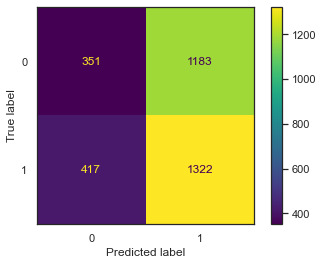

In [59]:
# Get predictions
y_preds_logreg = gs_logreg.predict(X_test)
# Save confusion matrix values
cm_logreg = confusion_matrix(y_test, y_preds_logreg)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cm_logreg, 
                       display_labels=gs_logreg.classes_).plot();

In [60]:
# baseline score
y_train.value_counts(normalize = True).mul(100).round(2)

1    53.12
0    46.88
Name: cAGR, dtype: float64

Thre accuarcy scores from logistic regression model is roughly about the same as baseline score, thus the logistic regression model does not perform well
in predicting cARG personality from facebook status post. 

### Summary of Naive Bayes 

Naive Bayes is a classification technique that relies on probability to classify observations.
- It's based on a probability rule called **Bayes' Theorem**... thus, "**Bayes**."
- It makes an assumption that isn't often met, so it's "**naive**."

Despite being a model that relies on a naive assumption, it often performs pretty well! (This is kind of like linear regression... we aren't always guaranteed homoscedastic errors in linear regression, but the model might still do a good job regardless.)
- [Interested in details? Read more here if you want.](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf)


The [sklearn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) is here, but it can be intimidating. So, to quickly summarize the Bayes and Naive parts of the model...

#### Bayes' Theorem
If you've seen Bayes' Theorem, it relates the probability of $P(A|B)$ to $P(B|A)$. (Don't worry; we won't be doing any probability calculations by hand! However, you may want to refresh your memory on conditional probability from our earlier lessons if you forget what a conditional probability is.)

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

- Let $A$ be that someone is "agreeable," like the OCEAN category.
- Let $B$ represent the words used in their Facebook post.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{person is agreeable}|\text{words in Facebook post}) &=& \frac{P(\text{words in Facebook post}|\text{person is agreeable})P(\text{person is agreeable})}{P(\text{words in Facebook post})}
\end{eqnarray*}
$$

We want to calculate the probability that someone is agreeable **given** the words that they used in their Facebook post! (Rather than calculating this probability by hand, this is done under the hood and we can just see the results by checking `.predict_proba()`.) However, this is exactly what our model is doing. We can (a.k.a. the model can) calculate the pieces on the right-hand side of the equation to give us a probability estimate of how likely someone is to be agreeable given their Facebook post.

#### Naive Assumption

If our goal is to estimate $P(\text{person is agreeable}|\text{words in Facebook post})$, that can be quite tricky.

---

<details><summary>Bonus: if you want to understand why that's complicated, click here.</summary>
    
- The event $\text{"words in Facebook post"}$ is a complicated event to calculate.

- If a Facebook post has 100 words in it, then the event $\text{"words in Facebook post"} = \text{"word 1 is in the Facebook post" and "word 2 is in the Facebook post" and }\ldots \text{ and "word 100 is in the Facebook post"}$.

- To calculate the joint probability of all 100 words being in the Facebook post gets complicated pretty quickly. (Refer back to the probability notes on how to calculate the joint probability of two events if you want to see more.)
</details>

---

To simplify matters, we make an assumption: **we assume that all of our features are independent of one another.**

In some contexts, this assumption might be realistic!

**12. Why would this assumption not be realistic with NLP data?**

Naturally, words used by people in a sentence are usually not independent of one another. There are some patterns in those word used. 

Despite this assumption not being realistic with NLP data, we still use Naive Bayes pretty frequently.
- It's a very fast modeling algorithm. (which is great especially when we have lots of features and/or lots of data!)
- It is often an excellent classifier, outperforming more complicated models.

There are three common types of Naive Bayes models: Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes.
- How do we pick which of the three models to use? It depends on our $X$ variable.
    - Bernoulli Naive Bayes is appropriate when our features are all 0/1 variables.
        - [Bernoulli NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
    - Multinomial Naive Bayes is appropriate when our features are variables that take on only positive integer counts.
        - [Multinomial NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)
    - Gaussian Naive Bayes is appropriate when our features are Normally distributed variables. (Realistically, though, we kind of use Gaussian whenever neither Bernoulli nor Multinomial works.)
        - [Gaussian NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

**13. Suppose you CountVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.**

CountVectorized features will result in positive integers, thus Multinomial Naive Bayes is the most appropriate to fit

**14. Suppose you TFIDFVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.**

TFIDFVectorized features will result in positive integers, thus Multinomial Naive Bayes is the most appropriate to fit

**15. Compare the performance of your models.**

The baseline accuracy score to predict the AGReeableness personality trait from Facebook status is 53.12%. The accuarcy scores from logistic regression model is roughly about the same as baseline score. The accuracy scores from Naive Bayes classifier model using Tfidf Vectorizer and Counter Vectorizer are slightly higher than the baseline accuracy score (1-2%). In general, the logistic regression model and Naive Bayes classifierdoes not perform well in predicting AGReeableness personality trait from Facebook status post. 

**16. Even though we didn't explore the full extent of Cambridge Analytica's modeling, based on what we did here, how effective was their approach at using Facebook data to model agreeableness?**

According to the results, the logistic regression model and Naive Bayes classifierdoes not effective in predicting AGReeableness personality trait from Facebook status post. 